# SI-ADRO
we introduce SI-ADRO, a method for making inferences on outliers detected by distributionally robust regression (DRO) using Selective Inference. Our goal is to perform statistical tests on each detected outlier to determine whether it is a true outlier. By accounting for selection bias, our selective p-value ensure the False Positive Rate (FPR) to be controlled at the significance level $\alpha$. We focus on the ambiguity set induced by $\ell_{1}$ and $\ell_{\inf}$ Wasserstein metric. Below, we provide a detailed step-by-step explanation of our approach, alongh a sample code.

## Preparation
Initially, we set the values for the parameterse.

In [13]:
Wasserstein_norm = "1" #string: either "1" or "inf": the norm of Wasserstein metric
epsilon = 0.1 # float: size of Wasserstein ball
N = 50  # int: number of instances
p = 1  # int: number of features
t = 2  # float: threshold-based anomaly detection
outlier_ratio = 0.1  # float: percentage of outliers in the simulated dataset
delta = 4  # float: outlier shift

## Generate a dataset and apply DRO to it
We import two custom functions that we developed: one for generating data and another for applying DRO.

In [14]:
from gen_data import generate_data
import numpy as np
beta = [i%2 + 1 for i in range(p)]
noise_sigma = np.identity(N)
X, y, outlier_idx = generate_data(N, p, sigma=noise_sigma, q_prob=outlier_ratio, delta=delta)

from DRO_regressor import DRO_AD
model = DRO_AD(epsilon=epsilon, Wasserstein_norm=Wasserstein_norm, threshold=t)
model.fit(X, y)

Let's examine the DRO-based AD results and compare them with the actual generated outliers. Please note that the indices provided in the list of outliers are 0-based.

In [15]:
outliers_set = model.get_AD()
print("Detected outliers = ", outliers_set)
print("True outliers = ", outlier_idx)

Detected outliers =  [10, 12, 13, 24, 25, 46]
True outliers =  [12, 13, 24, 25, 46]


Apply SI-ADRO to make inference on every outliers

In [16]:
from utils import calculate_p_value, identifying_truncated_region, calculate_SI_essentials
Selective_pvalues = {}
for j in outliers_set:
    etaT_yobs, etaT_Sigma_eta, a, b = calculate_SI_essentials(X, y, outliers_set, j, noise_sigma)
    Truncation_Region, _, _ = identifying_truncated_region(a, b, model, limit=20*np.sqrt(etaT_Sigma_eta))
    p_value = calculate_p_value(Truncation_Region, etaT_yobs, etaT_Sigma_eta)
    Selective_pvalues[j] = p_value

In [17]:
for i in outliers_set:
    p_value = Selective_pvalues[i]
    print(f"The p-value of {i + 1}(th) instance is: {p_value}")

The p-value of 11(th) instance is: 0.7560373605702868
The p-value of 13(th) instance is: 0.0033828929062975632
The p-value of 14(th) instance is: 1.240440916872032e-05
The p-value of 25(th) instance is: 6.214881112143189e-05
The p-value of 26(th) instance is: 7.386402606002207e-06
The p-value of 47(th) instance is: 0.004129115984742748


In the following plot

- True outlier: A genuinely abnormal data point
- Inlier: A normal data point
- Misclassified inlier: A normal data point incorrectly classified as an outlier.

Note: the float number inside the bracket of each outlier is its p-value

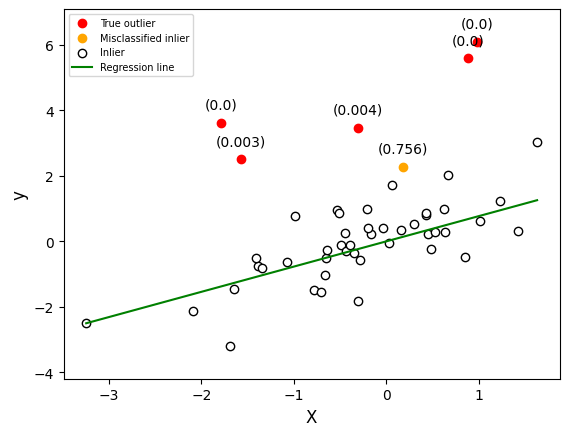

In [18]:
trueOutliersDetected = []
trueOutliers_pvalues = []
misclassified_inliner = []
misclassified_inliner_pvalues = []
normal_points = []
for i in range(N):
    if i in outliers_set:
        p_value = Selective_pvalues[i]
        if i in outlier_idx:
            trueOutliersDetected.append(i)
            trueOutliers_pvalues.append(p_value)
        else:
            misclassified_inliner.append(i)
            misclassified_inliner_pvalues.append(p_value)
    else:
        normal_points.append(i)

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X[trueOutliersDetected], y[trueOutliersDetected], color = "red", label = "True outlier")
plt.scatter(X[misclassified_inliner], y[misclassified_inliner], color = "orange", label = "Misclassified inlier")
plt.scatter(X[normal_points], y[normal_points], facecolor = "white", edgecolor = "black", label = "Inlier")
plt.plot(np.linspace(min(X), max(X), 100), model.predict(np.linspace(min(X), max(X), 100).reshape((100, p))), color = "green", label = "Regression line")
for i in range(len(trueOutliersDetected)):
    plt.annotate(f'({round(trueOutliers_pvalues[i], 3)})', (X[trueOutliersDetected[i]], y[trueOutliersDetected[i]]), textcoords="offset points", xytext=(0, 10), ha='center')
for i in range(len(misclassified_inliner)):
    plt.annotate(f'({round(misclassified_inliner_pvalues[i], 3)})', (X[misclassified_inliner[i]], y[misclassified_inliner[i]]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("X", size = 12)
plt.ylabel("y", size = 12)
plt.legend(fontsize = 7)
plt.ylim(min(y) - 1, max(y) + 1)
plt.savefig("./results/demonstration")